# Lab05: Regularization Assignment
---
111062117 黃祥陞

In this assignment, we would like to predict the success of shots made by basketball players in the NBA.

In [125]:
import pandas as pd
import numpy as np
import urllib.request
import os

if not os.path.exists("data/") : os.mkdir("data/")

urllib.request.urlretrieve("https://nthu-datalab.github.io/ml/labs/05_Regularization/data/X_train.csv", "./data/X_train.csv")
urllib.request.urlretrieve("https://nthu-datalab.github.io/ml/labs/05_Regularization/data/y_train.csv", "./data/y_train.csv")
urllib.request.urlretrieve("https://nthu-datalab.github.io/ml/labs/05_Regularization/data/X_test.csv", "./data/X_test.csv")

('./data/X_test.csv', <http.client.HTTPMessage at 0x32dd0eb80>)

In [126]:
X_train = pd.read_csv('./data/X_train.csv')
y_train = pd.read_csv('./data/y_train.csv')
X_test = pd.read_csv('./data/X_test.csv')

## 1. Use all features to train any linear model in scikit-learn and try different hyperparameters.
I used the RidgeClassifier model. I split the data into training and validation sets, and then experimented with different polynomial degrees to control the model’s complexity, as well as various alpha values to adjust regularization. The best model was selected based on the highest validation accuracy.

In [127]:
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
import pandas as pd

# Standardize the data
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

degrees = [1, 2, 3, 4, 5]
results = []

for d in degrees:
    poly = PolynomialFeatures(degree=d)
    X_train_poly = poly.fit_transform(X_train_std)
    
    # Split into training and validation sets
    X_train_split, X_valid_split, y_train_split, y_valid_split = train_test_split(
        X_train_poly, y_train, test_size=0.3, random_state=0)

    alphas = [1, 10, 100, 1000, 10000]
    for alpha in alphas:
        ridge_clf = RidgeClassifier(alpha=alpha)
        ridge_clf.fit(X_train_split, y_train_split.values.ravel())
        
        # Predict
        y_train_pred_ridge = ridge_clf.predict(X_train_split)
        y_valid_pred_ridge = ridge_clf.predict(X_valid_split)
        
        # Accuracy score
        acc_train_ridge = accuracy_score(y_train_split, y_train_pred_ridge)
        acc_valid_ridge = accuracy_score(y_valid_split, y_valid_pred_ridge)
        
        # Store RidgeClassifier results
        results.append({
            'model': 'RidgeClassifier',
            'degree': d,
            'alpha': alpha,
            'acc_train': acc_train_ridge,
            'acc_valid': acc_valid_ridge
        })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)
print(results_df)

              model  degree  alpha  acc_train  acc_valid
0   RidgeClassifier       1      1   0.607963   0.609656
1   RidgeClassifier       1     10   0.608013   0.609656
2   RidgeClassifier       1    100   0.607797   0.609461
3   RidgeClassifier       1   1000   0.608163   0.609656
4   RidgeClassifier       1  10000   0.609429   0.609500
5   RidgeClassifier       2      1   0.617693   0.614942
6   RidgeClassifier       2     10   0.617776   0.614903
7   RidgeClassifier       2    100   0.617826   0.614281
8   RidgeClassifier       2   1000   0.617343   0.613504
9   RidgeClassifier       2  10000   0.616043   0.611560
10  RidgeClassifier       3      1   0.618875   0.613698
11  RidgeClassifier       3     10   0.618859   0.613854
12  RidgeClassifier       3    100   0.618925   0.613893
13  RidgeClassifier       3   1000   0.619175   0.614126
14  RidgeClassifier       3  10000   0.618809   0.612493
15  RidgeClassifier       4      1   0.621291   0.610666
16  RidgeClassifier       4    

## 2. Select 1 setting (model + hyperparameters) and plot the error curve to show that the setting you selected isn't over-fit.
In this code, I identified the best model by selecting the one with the highest validation accuracy from the results. I printed the corresponding degree and alpha values, along with the training and validation accuracy scores for the best model. Then, I plotted the training and validation accuracy curves for the selected model and hyperparameters across different polynomial degrees. The plot illustrates that the selected model is not overfitted, as the training and validation accuracies remain close to each other, indicating good generalization performance.

Best model parameters:
Model:  RidgeClassifier
Degree:  2
Alpha:  1
Training Accuracy:  0.6176926280716368
Validation Accuracy:  0.6149420819404493


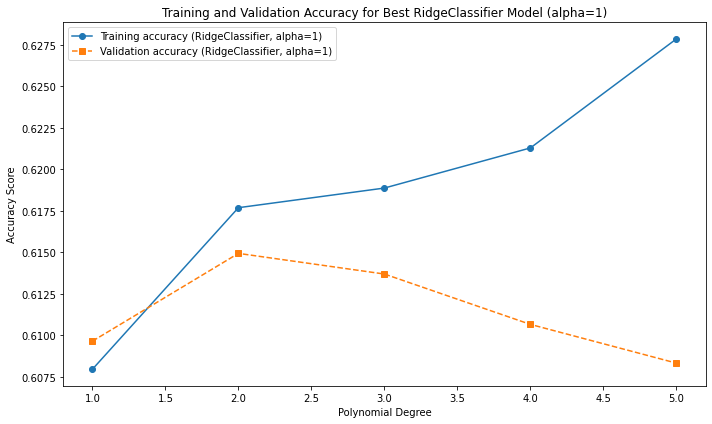

In [128]:
import matplotlib.pyplot as plt

# Find the model with the highest validation accuracy
best_model = results_df.loc[results_df['acc_valid'].idxmax()]

# Its info
print("Best model parameters:")
print("Model: ", best_model['model'])
print("Degree: ", best_model['degree'])
print("Alpha: ", best_model['alpha'])
print("Training Accuracy: ", best_model['acc_train'])
print("Validation Accuracy: ", best_model['acc_valid'])

best_model_type, best_alpha = best_model['model'], best_model['alpha']

# Select the results for the best alpha and model type
df_best_alpha_model = results_df[(results_df['alpha'] == best_alpha) & (results_df['model'] == best_model_type)]

# Plot the accuracy curves
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df_best_alpha_model['degree'], df_best_alpha_model['acc_train'], 
        label=f'Training accuracy ({best_model_type}, alpha={best_alpha})', marker='o')
ax.plot(df_best_alpha_model['degree'], df_best_alpha_model['acc_valid'], 
        label=f'Validation accuracy ({best_model_type}, alpha={best_alpha})', marker='s', linestyle='--')

ax.set_xlabel('Polynomial Degree')
ax.set_ylabel('Accuracy Score')
ax.set_title(f'Training and Validation Accuracy for Best {best_model_type} Model (alpha={best_alpha})')
ax.legend(loc='best')
plt.tight_layout()
plt.show()

## 3. Use any method to choose the best 3 features that can best aid the model's prediction.
To select the best 3 features, I expanded the polynomial features and trained a RidgeClassifier model with the optimal hyperparameters. I used SelectFromModel to automatically identify important features based on the coefficients of the model. The features with coefficients above the mean threshold were selected. Finally, I printed the top 10 features based on the absolute values of their coefficients, and I manually chose the 3 most important features (SHOT_DIST, CLOSE_DEF_DIST, TOUCH_TIME) from this set. And the 3 features satisfy the constraint that combination of features doesn't count as 1 feature.

In [129]:
from sklearn.linear_model import RidgeClassifier
from sklearn.feature_selection import SelectFromModel
import pandas as pd
import numpy as np

best_degree = int(best_model['degree'])
best_alpha = int(best_model['alpha'])

poly = PolynomialFeatures(degree=best_degree)
X_train_poly = poly.fit_transform(X_train_std)
X_test_poly = poly.fit_transform(X_test_std)

model = RidgeClassifier(alpha=best_alpha)
model.fit(X_train_poly, y_train.values.ravel())

# Use SelectFromModel to automatically select important features
selector = SelectFromModel(model, prefit=True, threshold='mean')
X_train_selected = selector.transform(X_train_poly)

# Find the names of the selected features
selected_features = poly.get_feature_names_out(X_train.columns)[selector.get_support()]

# Select the top 10 most important features based on coefficients
top_features = pd.Series(model.coef_.flatten(), index=poly.get_feature_names_out(X_train.columns)).abs().sort_values(ascending=False).head(10)
print("\nTop 10 selected features based on coefficients:")
print(top_features)


Top 10 selected features based on coefficients:
SHOT_DIST                   0.325977
CLOSE_DEF_DIST              0.196050
SHOT_DIST^2                 0.164239
SHOT_DIST PTS_TYPE          0.131152
SHOT_DIST CLOSE_DEF_DIST    0.108730
TOUCH_TIME                  0.065680
PTS_TYPE^2                  0.051484
PTS_TYPE                    0.046545
SHOT_CLOCK DRIBBLES         0.045977
TOUCH_TIME SHOT_DIST        0.042993
dtype: float64


## 4. Train the model selected in 2. with the only 3 features selected in 3., and present the training error.
In this step, I retrained the model selected in step 2 using only the 3 features chosen in step 3. Then, I printed the training accuracy to evaluate the model’s performance on the training set. The accuracy score reflects the model’s ability to correctly classify the data with the selected features.

In [130]:
from sklearn.metrics import accuracy_score

# Desired features
desired_features = ['SHOT_DIST', 'CLOSE_DEF_DIST', 'TOUCH_TIME']
top_feature_indices = [i for i, feature in enumerate(poly.get_feature_names_out(X_train.columns)) if feature in desired_features]

# Train the model using only the selected 3 features
X_train_top = X_train_poly[:, top_feature_indices]
X_test_top = X_test_poly[:, top_feature_indices]

# Retrain the model
model_top = RidgeClassifier(alpha=best_alpha)
model_top.fit(X_train_top, y_train.values.ravel())

# Predict
y_train_pred_top = model_top.predict(X_train_top)

# Accuracy score
train_accuracy_top = accuracy_score(y_train, y_train_pred_top)

print(f"\nTraining accuracy with SHOT_DIST, CLOSE_DEF_DIST, and DRIBBLES TOUCH_TIME: {train_accuracy_top:.2f}")


Training accuracy with SHOT_DIST, CLOSE_DEF_DIST, and DRIBBLES TOUCH_TIME: 0.60


## 5. Export the predictions of the model trained in 4. for X_test (follow the format of y_train.csv).
In this step, I exported the predictions from the model trained in step 4 using the 3 selected features for the test set.

In [131]:
y_test_pred_top = model_top.predict(X_test_top)

# Create the submission file format
submission = pd.DataFrame({
    'FGM': y_test_pred_top
})

# Save the results as a CSV file
submission.to_csv('Lab05_111062117_y_pred.csv', index=False)

print("\nPrediction results have been saved to 'Lab05_111062117_y_pred.csv'.")


Prediction results have been saved to 'Lab05_111062117_y_pred.csv'.


## 6. A brief report of what you have done in this assignment.
In this assignment, I used RidgeClassifier to train a model using all features with different polynomial degrees and alpha values. The goal was to find the optimal hyperparameters and degree. I selected the best model based on the highest validation accuracy.

Next, I chose the 3 most important features (SHOT_DIST, CLOSE_DEF_DIST, and TOUCH_TIME) and retrained the model using only these features. I evaluated the performance of this reduced feature set by calculating the accuracy.

Finally, I exported the predictions of the retrained model for the test set as a CSV file.